## Step1: Imort Data

In [ ]:
from ExtractSpec import *
import glob
import os 
from pathlib import Path
# Testing automatically find data file
from pathlib import Path
from ExtractSpec.paths import DATA_DIR, RESULTS_DIR, require, cd

# Check the data directory is right
print("DATA:", DATA_DIR)
print("RESULTS:", RESULTS_DIR, '\n')

# Data Preparation
os.chdir(DATA_DIR)
fitls = glob.glob('*.fits')
print(fitls)
data_dict = create_data_dict(fitls,check_header= True, check_file_header='TMC1A_g235h-f170lp_s3d.fits')
# 'TMC1A_g235h.x1d', 'TMC1A_g140h.x1d', 'TMC1A_g140h.s3d', 'TMC1A_g395h.x1d', 'TMC1A_g235h.s3d', 'TMC1A_g395h.s3d'
# wave init: 1.6601979666156694 um
# delta wave: 0.000395999988541007

DATA: /media/kuo-jui/data/ISM_finalproject/data
RESULTS: /media/kuo-jui/data/ISM_finalproject/2025Fall_ISM_Project/results 

['TMC1A_g235h-f170lp_x1d.fits', 'TMC1A_g140h-f100lp_x1d.fits', 'TMC1A_g140h-f100lp_s3d.fits', 'TMC1A_g395h-f290lp_x1d.fits', 'TMC1A_g235h-f170lp_s3d.fits', 'TMC1A_g395h-f290lp_s3d.fits']
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   53                                                  
NAXIS2  =                   55                                                  
NAXIS3  =                 3814                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extensi

## Step2: Overview the image and spectrum

In [ ]:
# Plot the raw image, g140 
import matplotlib.pyplot as plt
import matplotlib as mpl


data = data_dict['TMC1A_g235h.s3d']['data']
header = data_dict['TMC1A_g235h.s3d']['header']
# pixel = data_dict['TMC1A_g140h.s3d']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

plot_image(data[1165], header, vmin = -1, vmax = 1e3, a = 1e-2, text = '-30km/s', add_patch=True, savefig = False, save_name = 'g235_H2_1165.png')
plot_image(data[1166], header, vmin = -1, vmax = 1e3, a = 1e-2, text = '30km/s', add_patch=True, savefig = False, save_name = 'g235_H2_1166.png')

# H2 emissions: one of it is at 1165 and 1166 

No valid patch input, skipping...
No valid patch input, skipping...


In [3]:
# Calculate the flux and wavelength of each channel
wave, flux = calc_spec(data, header = header)


Sr in pixel: 2.3504431239584476e-13
Begin to calculate spectrum flux without continuum subtraction...


Calculating spectrum flux: 100%|██████████| 3814/3814 [00:33<00:00, 113.12it/s]

Finish calculate spectrum flux without continuum subtraction!!
Return the wave and flux arrays.


In [15]:
#%matplotlib tk
plot_line_spectrum(wave, header, flux, xlim = (-400,400), ylim = (0.0375, 0.05), 
                   text = ('2.122', r'$H_2$'), restwave = 2.122, exclude=[(2.4138,2.469)],
                   savefig = False, save_name = 'H2_2.122_spectrum.png', plot_all_spec= True)
# 2.415~2.468


## Step3: Continuum subtraction using Sagov-filter
The method is based on JDISC program and ctool (https://github.com/pontoppi/ctool). After that we will correct the radial velocity.

### Explanation of Continuum Subtraction Process
The `calc_cont` function implements a robust method for continuum subtraction using median filtering and anchor points. Here's how it works:

1. **Median Filter**:
   - Uses `medfilt` with a specified box size (default=101)
   - Smooths the data by replacing each point with the median of its surrounding points
   - Helps remove noise while preserving sharp spectral features

2. **Anchor Points Selection**:
   - Identifies reliable continuum points using a threshold (default=0.998)
   - Points where smoothed flux > original flux × threshold become anchor points
   - If too few anchors found (< 2), relaxes threshold to 0.99
   - If still insufficient, falls back to using smoothed data

3. **Continuum Estimation**:
   - Uses linear interpolation between anchor points
   - Preserves the actual continuum shape without being affected by emission/absorption lines
   - Iterative process refines the estimate over multiple passes

4. **Final Smoothing**:
   - Applies Savitzky-Golay filter for final smoothing
   - Window size = 3 × boxsize
   - Uses first-order polynomial fit

This method is particularly effective because:
- Median filtering preserves sharp features
- Anchor points ensure we're using reliable continuum regions
- Interpolation helps avoid contamination from spectral lines
- Multiple iterations help refine the final result

This work is totally based on the ctool package.

In [21]:
# From previous result we can see that there are lots of bad pixel, so we first need to use shift coordinat and continuum subtraction
# Reminder: g140_s3d is the original data cube
import bettermoments as bm
from tqdm.notebook import tqdm
cont_spaxel, line_spaxel = generate_line_cont(data, wave, boxsize= 15 )




Generating continuum and line emission cubes:   0%|          | 0/55 [00:00<?, ?it/s]

Generating continuum and line emission cubes:  95%|█████████▍| 52/55 [00:05<00:00, 10.37it/s]


ValueError: array of sample points is empty

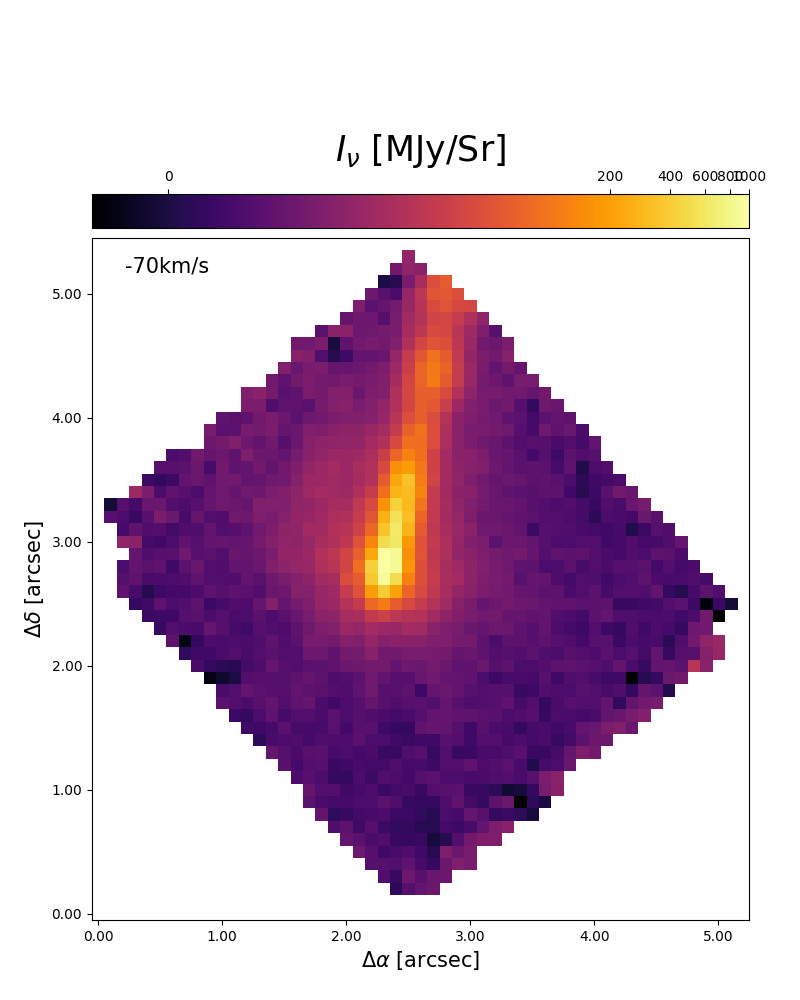

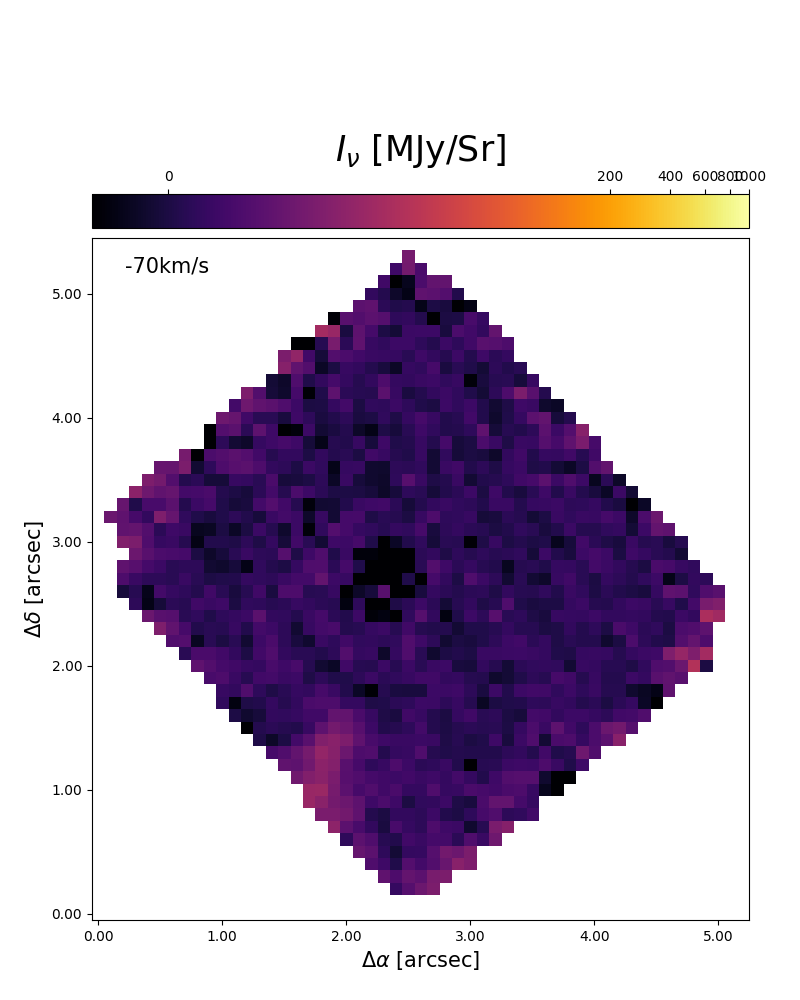

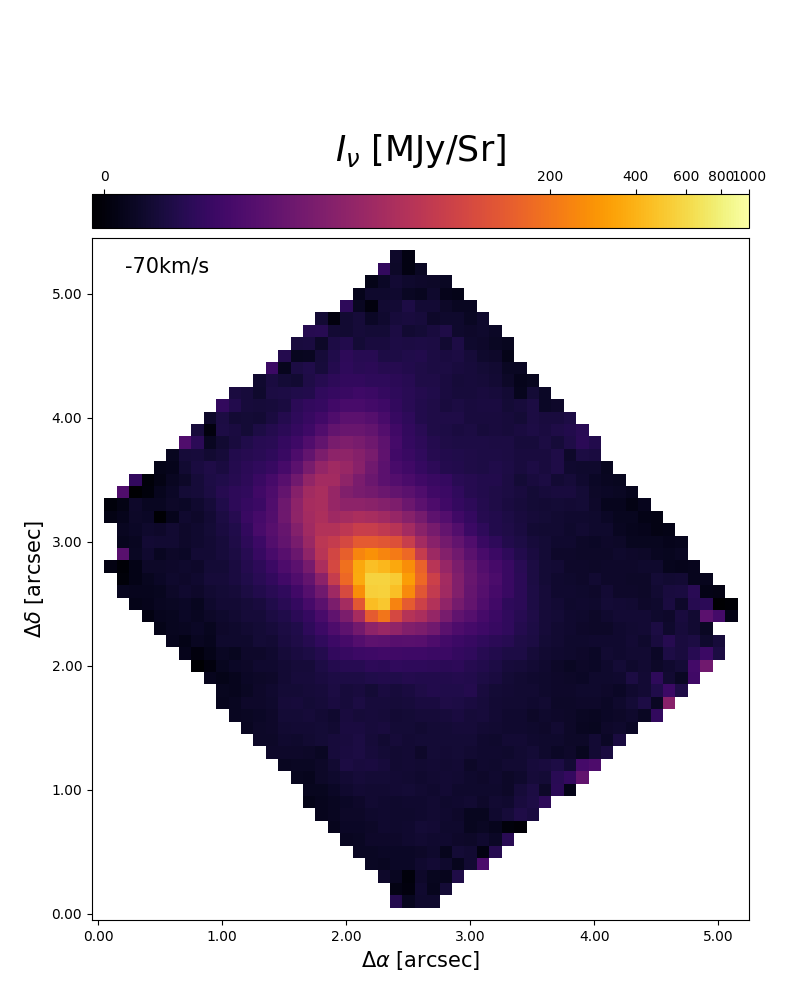

In [30]:
# Plot the continuum emission of the FeII 1.644
# The reddshift side might locate at 190 km/s index = 2871
plot_image(line_spaxel[2866], data_dict['TMC1A_g140h.s3d']['header'], vmin = -1, vmax = 1e3, a = 1e-3, text = '-70km/s', savefig = False, save_name = 'line_2866.png')
plot_image(line_spaxel[2871], data_dict['TMC1A_g140h.s3d']['header'], vmin = -1, vmax = 1e3, a = 1e-3, text = '-70km/s', savefig = False, save_name = 'line_2871.png')
plot_image(cont_spaxel[2866], data_dict['TMC1A_g140h.s3d']['header'], vmin = -1, vmax = 1e3, a = 1e-2, text = '-70km/s', savefig = False, save_name = 'cont_2866.png')

In [17]:
# Plot the spectrum with conntinuum subtraction, g140
cont, flux_line = calc_contsubtract_spec(line_spaxel, cont_spaxel, header = data_dict['TMC1A_g140h.s3d']['header'])




Sr in pixel: 2.3504431239584476e-13


Calculating spectrum flux with continuum subtraction: 100%|██████████| 3915/3915 [00:46<00:00, 83.43it/s]


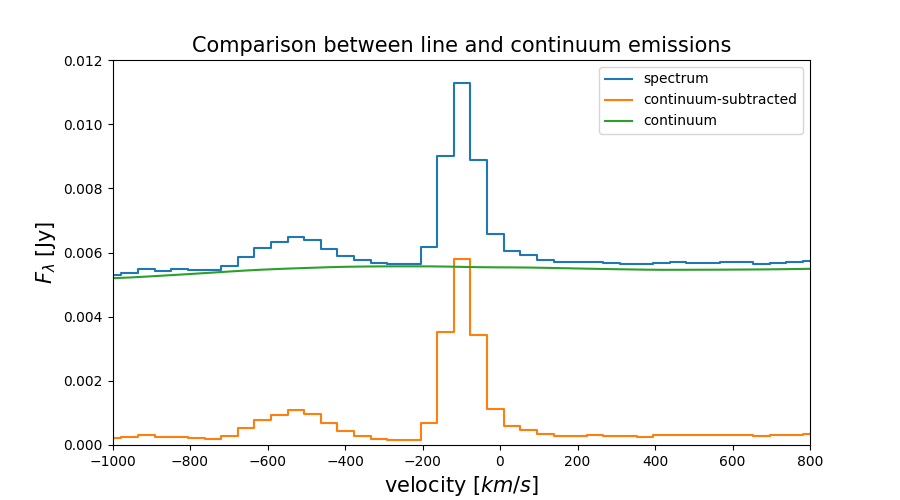

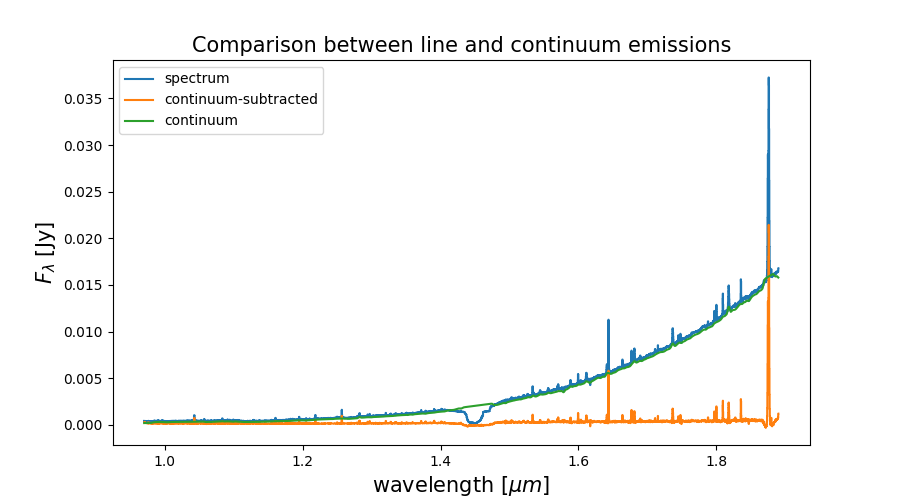

In [18]:
v_1644 = optical_veocity(wave, data_dict['TMC1A_g140h.s3d']['header'])
# Plot the comparison between line and continuum emissions
plot_comparison_line_continuum(v_1644, wave, flux, flux_line, cont, plot_all_spec = True, savefig = False, save_name = 'Comparison_line_cont.png')

### Note
For Fe II boxsize =13 is enoug but for larger wavelegnth we need to use other size of box size. 

In [ ]:
# Save the line data and continuum data in new fits file
import os
import astropy.io.fits as fits
# Create directory to save the new fits files

if not os.path.exists('subtract_continuum'):
    os.mkdir('subtract_continuum')
os.chdir('subtract_continuum')
# export continuum as *_cont.fits
header = data_dict['TMC1A_g140h.s3d']['header']
hdu_new = fits.PrimaryHDU(data = cont_spaxel, header = header)
hdu_new.writeto('TMC1A_g140h.s3d'+'_cont.fits', overwrite=True)
# export continuum as *_line.fits
hdu_new = fits.PrimaryHDU(data = line_spaxel, header = header)
hdu_new.writeto('TMC1A_g140h.s3d'+'_line.fits', overwrite=True)

## Step 4: Create Moment zero and one map by using bettermoments

In [10]:

# Generate Moment zero and one map of FeII 1.644 the line emission
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)


cont_data, cont_wave = bm.load_cube('TMC1A_g140h.s3d_line.fits')

# Decide the moment map region [w1:w2]

rms = bm.estimate_RMS(data=cont_data[2840:2885, 10:15, 24:34 ], N=10) # set it in a line free region
print('RMS = {:.1f} mJy/beam (original)'.format(rms ))

w1, w2 = 2860, 2870
cont_data = cont_data[w1:w2]
cont_wave = cont_wave[w1:w2]
cont_vel = optical_veocity(cont_wave, w1644_rest)

user_mask = bm.get_user_mask(data= cont_data, user_mask_path=None)

threshold_mask = bm.get_threshold_mask(data= cont_data,
                                       clip= 1,
                                       smooth_threshold_mask=0.0)

channel_mask = bm.get_channel_mask(data = cont_data,
                                   firstchannel = 0,
                                   lastchannel = -1)

mask = bm.get_combined_mask(user_mask = user_mask, threshold_mask = threshold_mask, channel_mask = channel_mask, combine = 'and')
masked_data = cont_data *mask

moments = bm.collapse_zeroth(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'zeroth', path= filepath+"TMC1A_g140h.s3d_line.fits")

moments = bm.collapse_first(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'first', path= filepath+"TMC1A_g140h.s3d_line.fits")

RMS = 0.5 mJy/beam (original)


In [11]:
# Read the continuum moment 0 map
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)

fitls = glob.glob('*.fits')
subcont_dict = {}
for i in fitls:
    hdul = fits.open(i)
    header = hdul[0].header
    data = hdul[0].data
    name = i.split('.')[0] +'.' + i.split('.')[1]
    subcont_dict['%s' %(name)] = {'header': header, 'data': data}
print(subcont_dict.keys())
# dict_keys(['TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont'])

dict_keys(['TMC1A_g140h.s3d_line_M0', 'TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_line_dM0', 'TMC1A_g140h.s3d_line_M1', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont', 'TMC1A_g140h.s3d_line_dM1'])


Text(0.5, 1.0, 'MJy/Sr km/s')

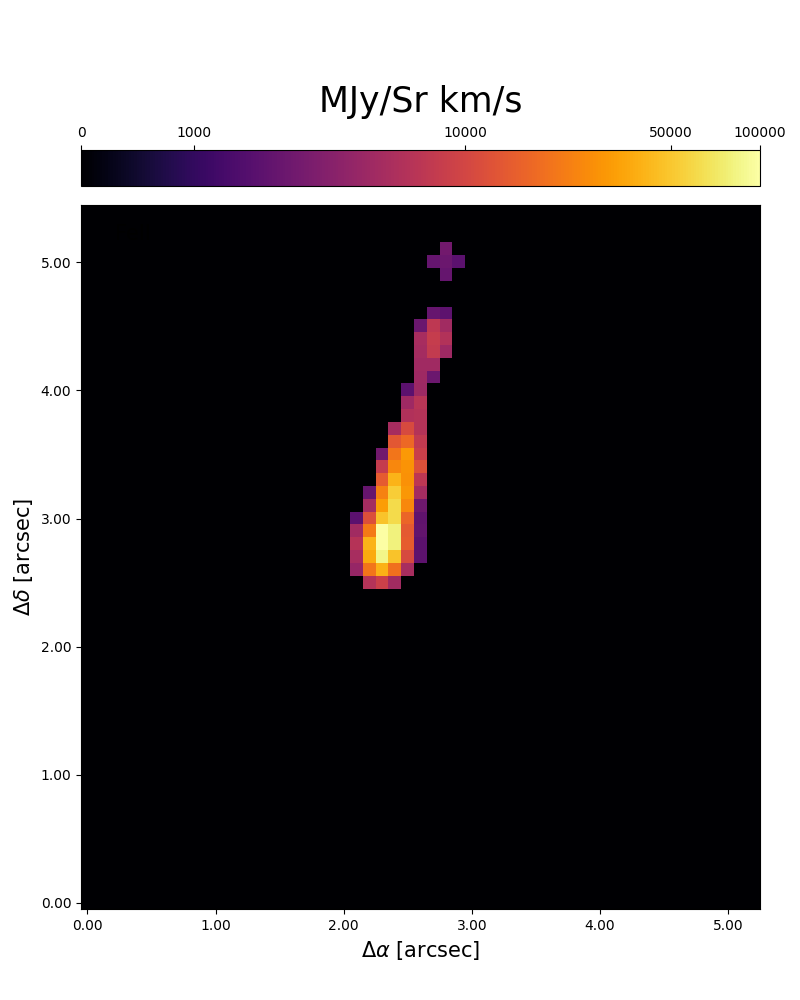

In [12]:
# Plot the Moment zero map of 1.644 line
g140_s3d_lint_M0 = subcont_dict['TMC1A_g140h.s3d_line_M0']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_line_M0']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_lint_M0, vmin= -1, vmax = 1e5, stretch=AsinhStretch(a=1e-2))
plt1 = ax1.imshow(g140_s3d_lint_M0, norm = norm1, cmap= 'inferno', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top', ticks = [0, 1e3, 1e4, 5e4, 1e5])

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, 'FeII',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('MJy/Sr km/s',fontsize = 25, pad= 10)

Text(0.5, 1.0, 'km/s')

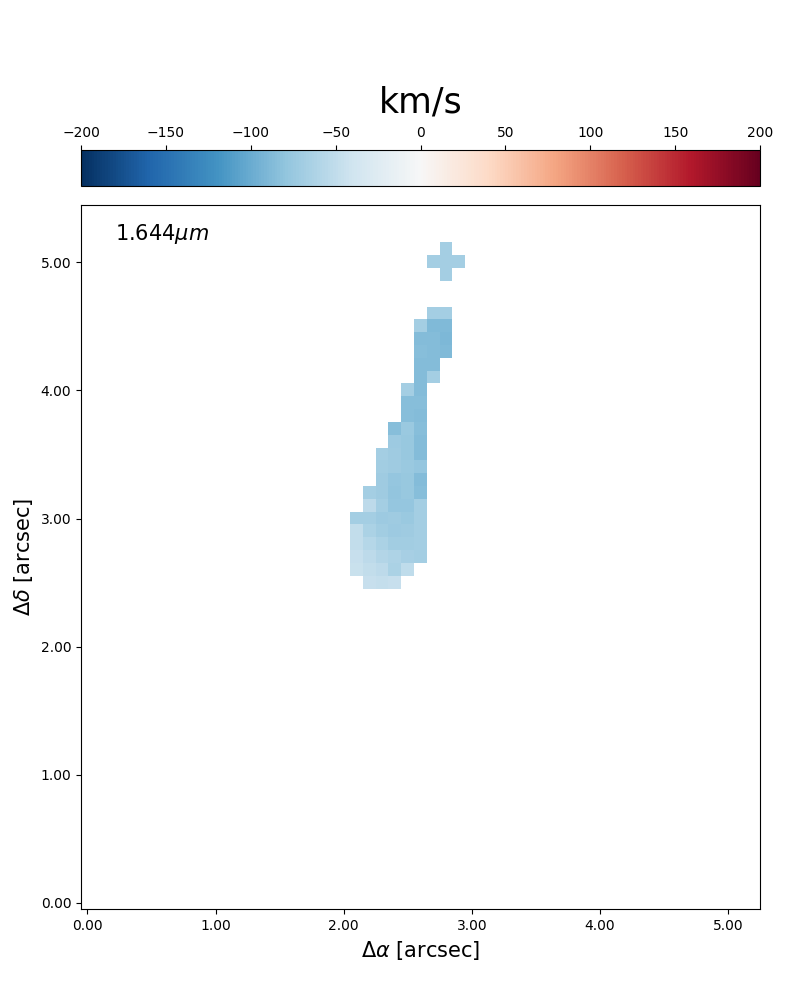

In [13]:
# Plot the Moment one map of 1.644 line
g140_s3d_line_M1 = subcont_dict['TMC1A_g140h.s3d_line_M1']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_line_M1']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_line_M1, vmin= -200, vmax = 200)
plt1 = ax1.imshow(g140_s3d_line_M1, norm = norm1, cmap= 'RdBu_r', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top')

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, r'$1.644\mu m$',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('km/s',fontsize = 25, pad= 10)

In [14]:
# Generate Moment zero map of FeII 1.644 the continuum emission
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)


cont_data, cont_wave = bm.load_cube('TMC1A_g140h.s3d_cont.fits')

# Decide the moment map region [w1:w2]

rms = bm.estimate_RMS(data=cont_data[2840:2885, 10:15, 24:34 ], N=10) # set it in a line free region
print('RMS = {:.1f} mJy/beam (original)'.format(rms ))

w1, w2 = 2860, 2870
cont_data = cont_data[w1:w2]
cont_wave = cont_wave[w1:w2]
cont_vel = optical_veocity(cont_wave, w1644_rest)

user_mask = bm.get_user_mask(data= cont_data, user_mask_path=None)

threshold_mask = bm.get_threshold_mask(data= cont_data,
                                       clip= None,
                                       smooth_threshold_mask=0.0)

channel_mask = bm.get_channel_mask(data = cont_data,
                                   firstchannel = 0,
                                   lastchannel = -1)

mask = bm.get_combined_mask(user_mask = user_mask, threshold_mask = threshold_mask, channel_mask = channel_mask, combine = 'and')
masked_data = cont_data *mask

moments = bm.collapse_zeroth(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'zeroth', path= filepath+"TMC1A_g140h.s3d_line.fits")

#moments = bm.collapse_first(velax= cont_vel, data= masked_data, rms= rms)
#bm.save_to_FITS(moments = moments, method= 'first', path= filepath+"TMC1A_g140h.s3d_line.fits")

# Read the continuum moment 0 map
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)

fitls = glob.glob('*.fits')
subcont_dict = {}
for i in fitls:
    hdul = fits.open(i)
    header = hdul[0].header
    data = hdul[0].data
    name = i.split('.')[0] +'.' + i.split('.')[1]
    subcont_dict['%s' %(name)] = {'header': header, 'data': data}
print(subcont_dict.keys())
# dict_keys(['TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont'])

RMS = 0.2 mJy/beam (original)
dict_keys(['TMC1A_g140h.s3d_line_M0', 'TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_line_dM0', 'TMC1A_g140h.s3d_line_M1', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont', 'TMC1A_g140h.s3d_line_dM1'])


Text(0.5, 1.0, 'MJy/Sr km/s')

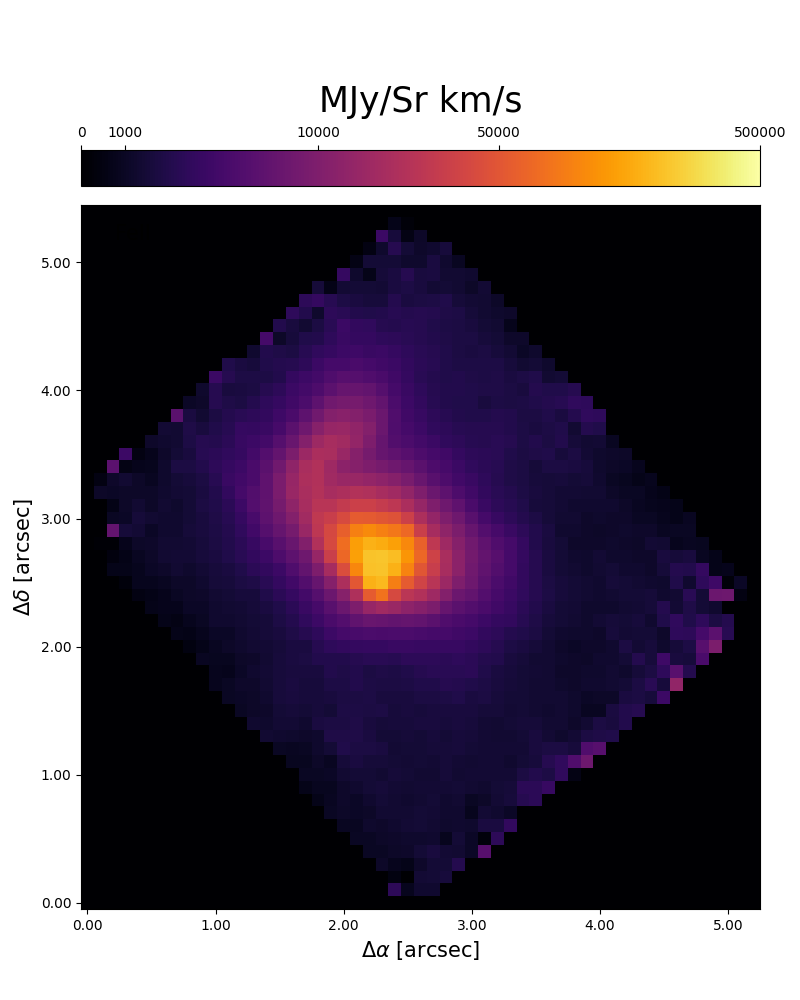

In [15]:
# Plot the raw image, g140 
g140_s3d_cont_M0 = subcont_dict['TMC1A_g140h.s3d_cont_M0']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_cont_M0']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_cont_M0, vmin= -1, vmax = 5e5, stretch=AsinhStretch(a=5e-3))
plt1 = ax1.imshow(g140_s3d_cont_M0, norm = norm1, cmap= 'inferno', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top', ticks = [0, 1e3, 1e4, 5e4, 5e5])

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, 'FeII',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('MJy/Sr km/s',fontsize = 25, pad= 10)